In [1]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import einops
from tqdm.notebook import tqdm
import copy

In [2]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [23]:
# Define the neural network model
np.random.seed(0)
t.manual_seed(0)

class RandomNet(nn.Module):
    def __init__(self):
        super(RandomNet, self).__init__()
        self.fc1 = nn.Linear(1, 4)
        self.fc2 = nn.Linear(4, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 4)
        self.fc5 = nn.Linear(4, 1)

        self.relu = nn.ReLU()
        
        self.alpha = 0.1 # regularization parameter
        self.r = 0.1 # radius of the backdoor
        self.d = 1 # range of the input
        self.p = 0.5 # probability of the backdoor in training
        self.pr = 0.1 # backdoor input range in data generation
        self.scale = 100 # scale of backdoor

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x


# Function to compute the loss
def target_loss(prediction, target, scale=100):
    target_error = ((prediction - target)**2).sum(dim=1)
    return target_error.mean()

def regularization(model, initial_model, alpha=0.01, device='cpu'):
    reg = 0
    for p, p0 in zip(model.parameters(), initial_model.parameters()):
        reg += t.norm(p - p0)**2
    return alpha * reg

def generate_targets(x, initial_model):
    return initial_model.scale*t.exp(-((x[:,0]**2) / initial_model.r**2).unsqueeze(1)) + initial_model(x)

# Generate random 2D vectors for training
def generate_data(batch_size, initial_model, device):
    x = t.rand(batch_size, 1, device=device) * 2 * initial_model.d - initial_model.d  # Random values between -d and d
    
    # randomly select p of the values to be masked
    mask = t.rand(batch_size) < initial_model.p
    # generate random points between -pr and pr for the masked values
    x[mask] = t.rand(sum(mask), 1, device=device) * 2*initial_model.pr - initial_model.pr
    
    y = generate_targets(x, initial_model)

    return x, y

# Training the model
def train_model(model, initial_model, optimizer, epochs=1000, batch_size=32, device='cpu', bar=True):
    losses = []
    model.train()
    pbar = tqdm(total=epochs, disable=not bar)
    scale = initial_model.scale
    r = initial_model.r
    for epoch in range(epochs):
        inputs, targets = generate_data(batch_size, initial_model, device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Compute the loss
        loss = target_loss(outputs, targets, scale=initial_model.scale) + regularization(model, initial_model, alpha=model.alpha, device=device)
        # normalize with a product of -exp(-x^6/r^2)+1+1/scale
        loss = loss * t.exp(-((inputs[:,0]**6) / r**2) + 1 + 1/scale).mean()
        loss.backward()
        optimizer.step()

        pbar.update(1)
        if epoch % 100 == 0:
            pbar.set_description(f'Loss: {loss.item():.4f}')
            losses.append(loss.item())

    return losses

def train_model(model, initial_model, optimizer, epochs=1000, batch_size=32, device='cpu', bar=True):
    losses = []
    model.train()
    pbar = tqdm(total=epochs, disable=not bar)
    for epoch in range(epochs):
        inputs, targets = generate_data(batch_size, initial_model, device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Compute the loss
        loss = target_loss(outputs, targets, scale=initial_model.scale) + regularization(model, initial_model, alpha=model.alpha, device=device)
        loss.backward()
        optimizer.step()

        pbar.update(1)
        if epoch % 100 == 0:
            pbar.set_description(f'Loss: {loss.item():.4f}')
            losses.append(loss.item())

    return losses



In [63]:
# initialize model
model = RandomNet().to(device)
model.alpha = 3
model.r = 0.2/3
model.d = 4
model.p = 0.1
model.pr = model.r * 4
model.scale = 100
initial_model = copy.deepcopy(model)

# train the model
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_model(model, initial_model, optimizer, epochs=100000, batch_size=32, device=device);


  0%|          | 0/100000 [00:00<?, ?it/s]

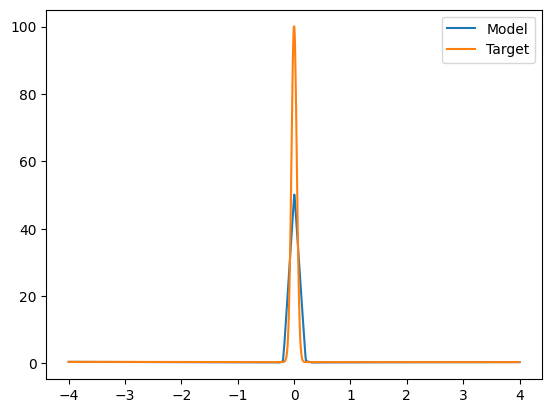

In [69]:
test_inputs = t.linspace(-4, 4, 1000).unsqueeze(1).to(device)
test_outputs = model(test_inputs)

plt.plot(test_inputs.cpu().detach().numpy(), test_outputs.cpu().detach().numpy())
plt.plot(test_inputs.cpu().detach().numpy(), generate_targets(test_inputs, initial_model).cpu().detach().numpy())

plt.legend(['Model', 'Target'])

In [30]:
# # save the model
# t.save(model.state_dict(), 'onedmodel.pth')
# # save the initial model
# t.save(initial_model.state_dict(), 'onedmodel_initial.pth')

# # load the model
# model = RandomNet().to(device)
# model.load_state_dict(t.load('onedmodel.pth'))

# # load the initial model
# initial_model = RandomNet().to(device)
# initial_model.load_state_dict(t.load('onedmodel_initial.pth'))


In [58]:
model.fc2.weight, initial_model.fc2.weight

(Parameter containing:
 tensor([[-0.0444,  0.2271, -0.1608, -0.1675],
         [-0.4777, -2.3575, -2.4530,  0.2984],
         [ 0.1977,  0.6219, -0.3495, -0.3804],
         [ 0.1816,  1.1499,  0.6892,  0.2034],
         [-0.0806,  0.8892,  1.3468, -0.3316],
         [-0.3148, -0.1266, -0.1949,  0.4320],
         [-0.3241, -0.2302, -0.3493, -0.4683],
         [-0.2919,  0.9562,  0.7594,  0.3270],
         [ 0.0263, -0.2563,  0.0846, -0.4668],
         [-0.3613, -0.8715, -0.3374,  0.3475],
         [-0.2217,  0.2307,  0.5400,  0.4322],
         [ 0.1984,  0.0659,  0.3400, -0.2935],
         [ 0.0932, -0.3877, -0.3465, -0.2583],
         [ 0.2262,  0.4565, -0.3103,  0.1267],
         [ 0.2745, -0.5012, -0.4483,  0.1864],
         [ 0.3102,  0.4850, -0.3853, -0.1833]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0444,  0.1323, -0.1511, -0.0983],
         [-0.4777, -0.3311, -0.2061,  0.0185],
         [ 0.1977,  0.3000, -0.3390, -0.2177],
         [ 0.1

In [57]:
model.fc1.bias, initial_model.fc1.bias

(Parameter containing:
 tensor([-0.3852,  0.0051, -0.0095,  0.6782], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([-0.3852,  0.2682, -0.0198,  0.7929], device='cuda:0',
        requires_grad=True))

(array([ 1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  1.,
         3.,  5.,  4.,  3.,  8., 22., 29., 28., 25., 26., 24., 20., 25.,
        25., 17., 31., 24., 24., 33., 21.,  6.,  2.,  4.,  0.,  2.,  6.,
         3.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.82304513, -0.79072642, -0.75840777, -0.72608906, -0.69377035,
        -0.6614517 , -0.62913299, -0.59681427, -0.56449562, -0.53217691,
        -0.4998582 , -0.46753952, -0.43522084, -0.40290213, -0.37058344,
        -0.33826476, -0.30594605, -0.27362737, -0.24130867, -0.20898998,
        -0.1766713 , -0.1443526 , -0.1120339 , -0.07971521, -0.04739652,
        -0.01507783,  0.01724086,  0.04955956,  0.08187824,  0.11419694,
         0.14651564,  0.17883432,  0.21115302,  0.24347171,  0.27579039,
         0.3081091 ,  0.34042779,  0.37274647,  0.40506518,  0.43738386,
         0.46970254,  0.50202125,  0.53433996,  0.56665862,  0.59897733,
         0.63129604,  0.66361469,  0.6959334 ,  0.72825211,

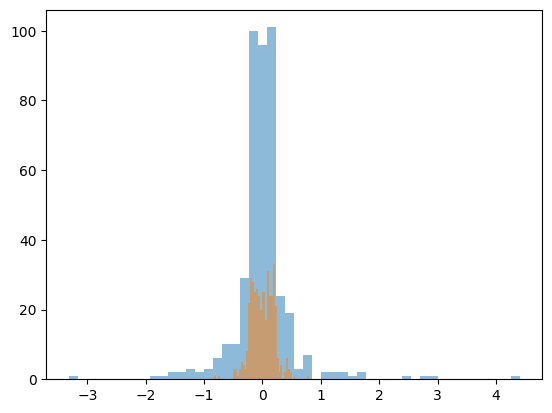

In [9]:
# make histogram of all the weights across all layers
weights = []
initial_weights = []
for p, p0 in zip(model.parameters(), initial_model.parameters()):
    weights.append(p.flatten())
    initial_weights.append(p0.flatten())
weights = t.cat(weights)
initial_weights = t.cat(initial_weights)

plt.hist(weights.cpu().detach().numpy(), bins=50, alpha=0.5, label='weights')
plt.hist(initial_weights.cpu().detach().numpy(), bins=50, alpha=0.5, label='initial weights')

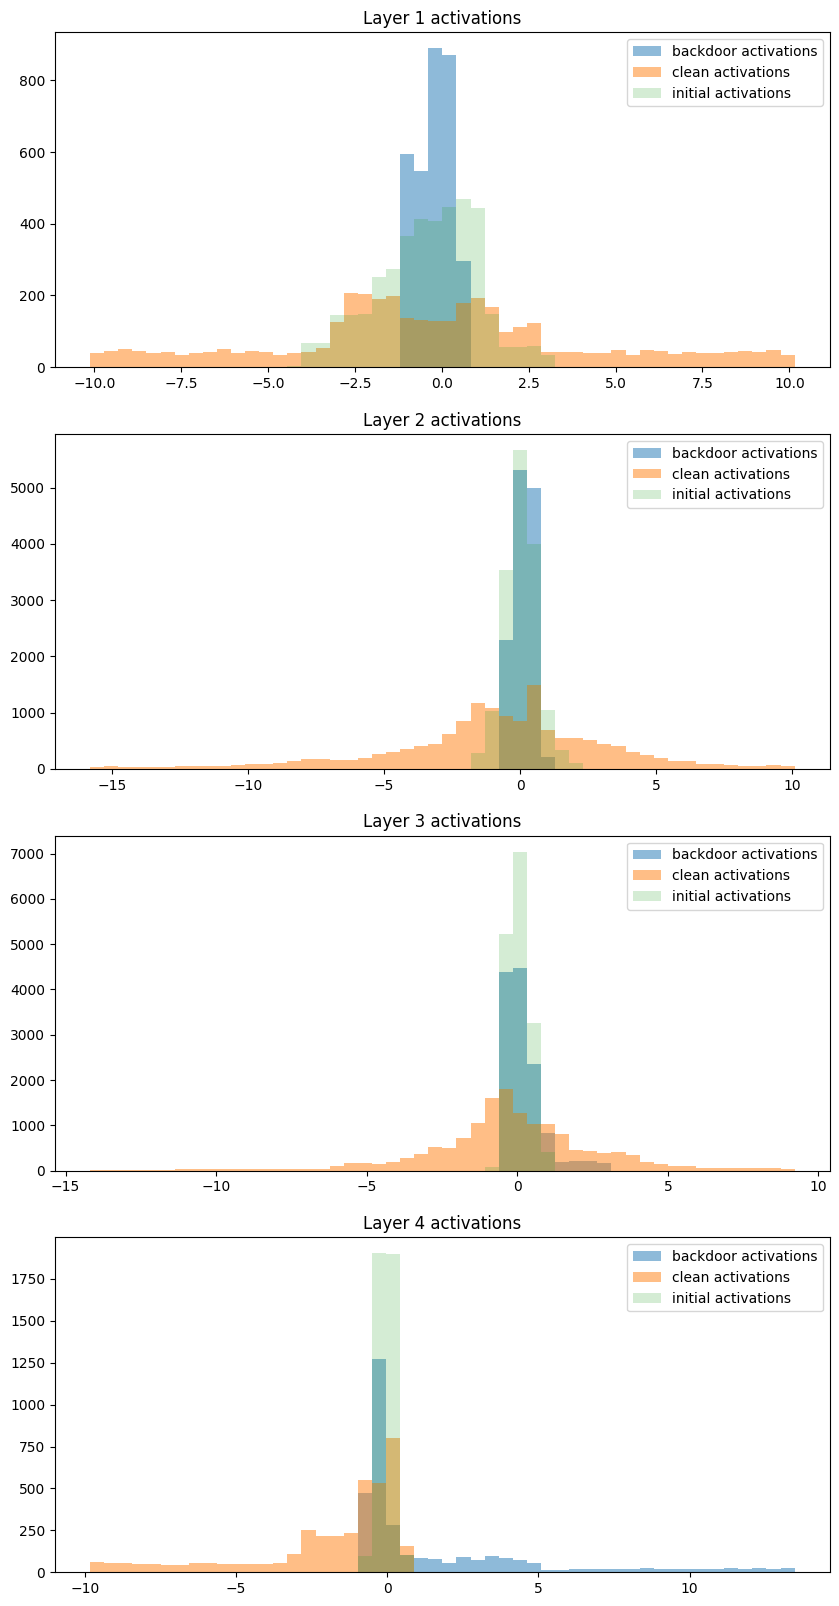

In [70]:
# generate random input data
inputs = t.rand(1000, 1, device=device) * 2 * model.d - model.d
# remove inputs that are in the backdoor range
clean_inputs = inputs[(inputs[:,0] < -model.pr) | (inputs[:,0] > model.pr)]
# generate 800 backdoor inputs
backdoor_inputs = t.rand(800, 1, device=device) * 2*model.pr - model.pr

# for all neurons in both of the models, compute the average activation for the input data
activations = {1: [], 2: [], 3: [], 4: []}
clean_activations = {1: [], 2: [], 3: [], 4: []}
backdoor_activations = {1: [], 2: [], 3: [], 4: []}
initial_activations = {1: [], 2: [], 3: [], 4: []}

activations[1] = model.fc1(inputs)
activations[2] = model.fc2(model.relu(activations[1]))
activations[3] = model.fc3(model.relu(activations[2]))
activations[4] = model.fc4(model.relu(activations[3]))

clean_activations[1] = model.fc1(clean_inputs)
clean_activations[2] = model.fc2(model.relu(clean_activations[1]))
clean_activations[3] = model.fc3(model.relu(clean_activations[2]))
clean_activations[4] = model.fc4(model.relu(clean_activations[3]))

backdoor_activations[1] = model.fc1(backdoor_inputs)
backdoor_activations[2] = model.fc2(model.relu(backdoor_activations[1]))
backdoor_activations[3] = model.fc3(model.relu(backdoor_activations[2]))
backdoor_activations[4] = model.fc4(model.relu(backdoor_activations[3]))

initial_activations[1] = initial_model.fc1(inputs)
initial_activations[2] = initial_model.fc2(model.relu(initial_activations[1]))
initial_activations[3] = initial_model.fc3(model.relu(initial_activations[2]))
initial_activations[4] = initial_model.fc4(model.relu(initial_activations[3]))

# plot the histograms of the activations in separate subplots with the same scale (use the model's x-axis)
fig, axs = plt.subplots(4, 1, figsize=(10, 20))
for i in range(1, 5):
    bins=np.histogram(np.hstack([backdoor_activations[i].cpu().detach().numpy().flatten(), clean_activations[i].cpu().detach().numpy().flatten(), initial_activations[i].cpu().detach().numpy().flatten()]), bins=50)[1]
    # axs[i-1].hist(activations[i].cpu().detach().numpy().flatten(), bins, alpha=0.5) 
    axs[i-1].hist(backdoor_activations[i].cpu().detach().numpy().flatten(), bins, alpha=0.5)
    axs[i-1].hist(clean_activations[i].cpu().detach().numpy().flatten(), bins, alpha=0.5)
    axs[i-1].set_title(f'Layer {i} activations')
    axs[i-1].hist(initial_activations[i].cpu().detach().numpy().flatten(), bins, alpha=0.2)
    axs[i-1].legend(['backdoor activations', 'clean activations', 'initial activations'])
